In [13]:
%matplotlib inline
import numpy as N
import pandas as P

# Let's Talk About Percentiles

The purpose of this notebook is to illustrate some of the unintuitive but profoundly impactful statistics of percentile estimation.

It's obvious to most engineers how important percentiles are to operating services. But it's not obvious how dramatically results can differ depending on how percentiles are calculated.

Using theory and some real world examples, I'll try to demonstrate why percentile statistics behave so unintuitively and how subtle differences in method can profoundly impact your numbers. In the process, I'll offer some pointers for avoiding these pitfalls.

## In which we define an SLA

Let's start with a common problem—measuring latency.

Suppose service x advertises that it can serve requests with a p99 of 100ms. That's not bad! They prove this to you by showing you a grafana dashboard that might look something like this:

<img src="grafana.png" width=50% height=50%>

We all know dashboards never lie so you take their word for it. You shake hands on the proposed SLA and began to integrate against their service.

Since you're a responsible engineer, however, you instrument calls to their service anyway. What you see surprises you—their p99s are actually far higher than what their dashboard reports, and often exceeds their SLA!

Angrily, you stomp over to their pod and show them your findings.

"It must be network overhead or something wrong with your instrumentation," they respond, which just makes your blood boil.

"My instrumentation is perfect," you respond. "The problem is your service."

It turns out you're both wrong. The culprit was actually math.

## The Dataset
The rest of this notebook will transform and sample latency numbers to supplement theory, so we use this section to generate and analyze the dataset.

Since I'm too lazy to collect actual latency numbers, I'm going to make the assumption that latencies follow a power law distribution—that is, there's a long tail of very slow latencies.

In reality, this is a good enough model of real world latencies for our purposes.

In [136]:
df = P.DataFrame(N.random.power(0.2, 100000) * 110).round(2)

So we have a dataframe with 1 million latencies, a max of 110 ms distributed via the power law. Let's see how that looks in a histogram:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1149422d0>]], dtype=object)

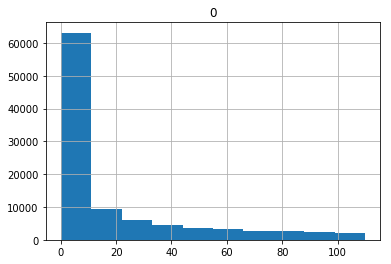

In [137]:
df.hist()

What about its median and p99?

In [138]:
df.describe(percentiles=[.99])

,0
count,100000.000000
mean,18.306192
std,27.649308
min,0.000000
50%,3.400000
99%,104.750100
max,109.990000


## The Central Limit Theorem

Before we continue with our story, let's review some stats.

You may recall from school that there's a handy thing called the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). The CLT basically says this: The average of a large enough sample will be pretty close to the "real" average, give or take some error.

This is pretty handy for measuring a lot of things—it means that even a relatively small sample can give us a pretty good measure of the population average.

Let's test this on our dataset.

In [142]:
df.sample(50).mean()

0    17.3088
dtype: float64

Not bad. Even with a sample of .05% of the population, we got a pretty close estimate of population mean.

Could've been a fluke. Let's do this procedure 75 more times:

In [143]:
mean_samples = P.DataFrame([df.sample(50).mean() for _ in range(1000)])
mean_samples.mean()

0    18.386895
dtype: float64

Nice, the average of all of our sample averages is pretty damn close to the real average. This is the central limit theorem in action!

## Percentiles are trickier

Unfortunately, the central limit theorem doesn't apply to percentiles. As proof, let's try the same procedure, but for the 99th percentile. As a reminder, the "real" p99 of our dataset is this:

In [145]:
float(df.quantile(.99))

104.75009999999995

So what happens if we get the p99 of a sample?

In [146]:
df.sample(50).quantile(.99)

0    94.2888
Name: 0.99, dtype: float64

Hm, seems a little off. What if we repeat this procedure a bunch of times?

In [148]:
P.DataFrame(df.sample(50).quantile(.99) for _ in range(1000)).mean()

0    95.015978
dtype: float64

The average of our percentiles doesn't converge to the actual p99! The average of many percentile estimates isn't the real value, unlike with the mean.

Ok, but what if we vary our sample size?

In [150]:
# 100 samples:
P.DataFrame(df.sample(100).quantile(.99) for _ in range(1000)).mean()

0    99.787503
dtype: float64

In [151]:
# 500 samples:
P.DataFrame(df.sample(500).quantile(.99) for _ in range(1000)).mean()

0    103.774149
dtype: float64

In [153]:
# 1000 samples
P.DataFrame(df.sample(1000).quantile(.99) for _ in range(1000)).mean()

0    104.182944
dtype: float64

Finally, at about 1000 samples, we have an estimate of the p99 with a reasonable amount of error.

## So what's happening?

Let's review what just happened. Two things are worth noting:

1. Our small sample underestimated the real p99 by 10%!
2. As we increased the sample size, we continued to underestimate. However, error decreased.

The intuition for this phenomenon is simple. It's harder for samples to capture the full range of data since they only have a fraction of the p

## So who cares?

Unavoidably, you'll explain this phenomenon to someone and they'll tell you that the effect is negligible. In some cases they may be right, so keep an open mind and remember what your requirements are.

In most cases they are egregiously underestimating how much error is being introduced.

Let's talk about a few real world cases.